# Feed-forward and backprop from scratch

### Take-home messages

* You can think of feed-forward NN as many interconnected logistic regressions.
* Shapes are important! If something isn't working, check that shapes makes sense.
* Weight matrix for the layer l has the shape ($N_{l-1}+1, N_l$).
* Log loss is a good loss function.
* Backprop is gradient descent on steroids.
* Two-neuron hidden layer has linear decision boundary.

### Feed-forward

<div>
<img src="feedforward.png" width="500"/>
</div>

In [1]:
# !pip install sklearn

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#### Step 1: Create training data

In [3]:
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=50, noise=0.15, random_state=42)

#### Step 2: Take a look at the data

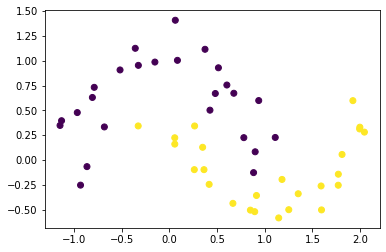

In [5]:
plt.scatter(X[:,0], X[:,1], c=y)

#### Step 3: Add a bias (parameter b) column to X

In [6]:
X.shape[0]

50

In [7]:
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

In [8]:
X = add_bias(X)

#### Step 4: calculate the sigmoid activation function

$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [10]:
a = np.array([-10.0, -1.0, 0.0, 1.0, 10.0])
expected = np.array([0.0, 0.27, 0.5, 0.73, 1.0])
assert np.all(sigmoid(a).round(2) == expected)

#### Step 5: Initialize the weights

In [11]:
n_neurons = 2

In [12]:
w = []
w.append(np.random.randn(X.shape[1], n_neurons)) # between innput and hidden
w.append(np.random.randn(n_neurons+1, 1)) # between hidden and output

In [13]:
w

[array([[-1.0705992 , -0.15272083],
        [ 1.28510852, -1.05293078],
        [-1.20730911, -0.66100005]]),
 array([[ 1.09944049],
        [ 0.56071046],
        [-1.86262014]])]

#### Step 6: Put it all together

In [14]:
def feed_forward(X, weights):

    """
    1. Multiply the input matrix X (shape of (50, 3))
       with the weights of the first layer (shape of (3, 2)),
       resulting in the matrix of the shape (50, 2)
    """
    step1 = np.dot(X, weights[0]) 

    """    
    2. Apply the sigmoid function on the result,
       preserving the shape (50, 2) 
    """
    step2 = sigmoid(step1)
    
    """    
    3. Append an extra column of ones to the result (i.e. the bias),
       resulting in the shape (50, 3)
    """
    step3 = add_bias(step2)

    """    
    4. Multiply the output of the previous step (shape of (50, 3))
       with the weights of the second (i.e. outer) layer (shape of (3, 1)),
       resulting in the shape (50, 1)
    """
    step4 = np.dot(step3, weights[1])
    
    """    
    5. Apply the sigmoid function on the result, shape remains (50, 1)
    """
    step5 = sigmoid(step4)
    
    """    
    6. Return all intermediate results (i.e. anything that
       an activation function outputs).
    """

    return step2, step5

In [15]:
out1, out2 = feed_forward(X, w)
assert out1.shape == (50, 2)
assert out2.shape == (50, 1)

Xref = np.array([[1.0, 2.0, 1.0]])
whidden = np.array([[1.0, 2.0, 0.0],
                 [-1.0, -2.0, 0.0]
                    ]).T
wout = np.array([[1.0, -1.0, 0.5]]).T

out1, out2 = feed_forward(Xref, [whidden, wout])
assert np.all(out1.round(2) == np.array([[0.99, 0.01]]))
assert np.all(out2.round(2) == np.array([[0.82]]))

### Backpropagation

Brief gradient descent recap:
* To find the optimal model we need:
    * A measure of how well our model is doing — _loss function_
    * A way to get from a bad model to a good model — _optimization algorithm_
* In linear regression:
    * Loss function is _MSE_
    * Optimization algorithm is _gradient descent_
* Here:
    * Loss function is _log loss_
    * Optimization algorithm is (basically) gradient (stochastic gradient descent / batch gradient descent)
* Gradient descent:
    $$ w_{new} = w_{old} - \alpha \nabla L(w) $$

<div>
<img src="neuron_w_backprop.png" width="500"/>
</div>

**Let's talk about loss function!**

* Here we'll use log loss as a loss function:
$$ loss = -(y_{true} log(y_{pred}) + (1-y_{true}) log(1-y_{pred})) $$

#### Step 1: Run feed-forward and make sure it works

Check!

#### Step 2: Write a Loss Function

##### 2a: Log-loss

$$ loss = -(y_{true} log(y_{pred}) + (1-y_{true}) log(1-y_{pred})) $$

In [16]:
def log_loss(ytrue, ypred):
    loss = -(ytrue*np.log(ypred)+(1-ytrue)*np.log(1-ypred)) 
    return loss

In [17]:
ytrue = np.array([0.0, 0.0, 1.0, 1.0])
ypred = np.array([0.01, 0.99, 0.01, 0.99])
expected = np.array([0.01, 4.61, 4.61, 0.01])
assert np.all(log_loss(ytrue, ypred).round(2) == expected)

##### 2b: Log-loss derivative

$$ loss' = -(\frac{y_{true}}{y_{pred}}-\frac{1-y_{true}}{1-y_{pred}}) $$

In [18]:
def log_loss_deriv(ytrue, ypred):
    loss_deriv = -(ytrue/ypred - (1-ytrue)/(1-ypred))
    return loss_deriv

In [19]:
a = np.array([0.5, 0.3, 0.99, 0.2])
b = np.array([0.4, 0.2, 0.10, 0.3])
expected = np.array([-0.42, -0.62, -9.89, 0.48])
assert np.all(log_loss_deriv(a, b).round(2) == expected)

##### Extra — 2c: Sigmoid derivative

$$ \sigma' = \sigma (1-\sigma) $$

In [20]:
def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

#### Step 3: Calculate initial loss

In [21]:
out1, out2 = feed_forward(X, w)
ytrue = y.reshape(-1, 1)

In [22]:
loss = log_loss(ytrue, out2)

In [23]:
[print(a, b, c) for (a, b, c) in zip(out2, ytrue, loss)]

[0.2380125] [0] [0.27182513]
[0.1722752] [1] [1.7586621]
[0.18543585] [1] [1.68504626]
[0.15937737] [1] [1.83648046]
[0.26122281] [0] [0.3027589]
[0.15660052] [1] [1.85405715]
[0.19608603] [1] [1.62920179]
[0.21894307] [1] [1.51894355]
[0.1806694] [1] [1.71108645]
[0.23770348] [0] [0.27141967]
[0.22605756] [0] [0.25625778]
[0.17591014] [0] [0.1934757]
[0.16736817] [1] [1.78755925]
[0.20121718] [0] [0.22466619]
[0.17487102] [0] [0.19221557]
[0.19056105] [0] [0.21141393]
[0.16742599] [1] [1.78721385]
[0.15617792] [1] [1.85675941]
[0.15608228] [1] [1.85737195]
[0.25427536] [0] [0.29339886]
[0.19115838] [0] [0.21215216]
[0.25591848] [0] [0.29560469]
[0.22945234] [0] [0.26065377]
[0.1765889] [1] [1.73393085]
[0.18259362] [1] [1.70049228]
[0.17177568] [0] [0.18847124]
[0.16279249] [1] [1.81527895]
[0.19763442] [1] [1.62133633]
[0.1742043] [1] [1.74752652]
[0.18594676] [0] [0.20572952]
[0.19253402] [1] [1.6474824]
[0.2162996] [0] [0.24372848]
[0.17250863] [1] [1.75730802]
[0.17149515] [0] [0.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Step 4: Write a backpropagation function

Fill in the blanks of the following function, which transcribes the equations from earlier (equations A - E) to run one iteration of the backpropagation algorithm. It takes in a handful of arguments:
* the initial weights,
* the outputs from the feed-forward process (i.e. both the hidden output and the final output),
* the true labels,
* the input data,
* and the learning rates (we’ll have a separate learning rate for each layer of the network).

The function (representing a single iteration of the backpropagation algorithm), should return the modified hidden weights and the modified outer weights.

In [24]:
def backprop(weights,
             output1,
             output2,
             ytrue,
             X_input,
             LR):

    wH = weights[0]
    wO = weights[1]

    '''EQUATION A:'''
    error = log_loss_deriv(___ , ___)

    '''EQUATION B:'''
    # don't forget the bias!
    hidden_out_with_bias = add_bias(___)
    # derivative of the sigmoid function with respect to the
    # hidden output * weights
    sig_deriv_1 = sigmoid_deriv( ___ )

    y_grad = sig_deriv_1 * error

    '''EQUATION C:'''
    delta_wo = -np.dot( ___.T, hidden_out_with_bias ) * LR

    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + ___.T

    '''EQUATION D:'''
    sig_deriv_2 = sigmoid_deriv( ___ )
    #exclude the bias (last column) of the outer weights,
    #since it is not backpropagated!
    H_grad = ___  * np.dot(y_grad , ___[:-1].T)

    '''EQUATION E:'''
    delta_wH = -np.___(H_grad.T, ___ ) * ___
    #old weights + delta weights -> new weights!
    wH_new = wH + ___.T

    # new hidden weights, new output weights
    return ___, ___

In [25]:
def backprop(weights,
             output1,
             output2,
             ytrue,
             X_input,
             LR):

    wH = weights[0]
    wO = weights[1]

    '''EQUATION A:'''
    error = log_loss_deriv(ytrue, output2)
    
    '''EQUATION B:'''
    #don't forget the bias!
    hidden_out_with_bias = add_bias(output1)
    #derivative of the sigmoid function with respect to the
    #hidden output * weights
    sig_deriv_1 = sigmoid_deriv(hidden_out_with_bias.dot(wO))
    y_grad = sig_deriv_1 * error

    '''EQUATION C:'''
    delta_wO = -np.dot(y_grad.T, hidden_out_with_bias) * LR

    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + delta_wO.T

    '''EQUATION D:'''
    sig_deriv_2 = sigmoid_deriv(X_input.dot(wH))
    #exclude the bias (last column) of the outer weights,
    #since it is not backpropagated!
    H_grad = sig_deriv_2 * np.dot(y_grad , wO[:-1].T)
    
    '''EQUATION E:'''
    delta_wH = -np.dot(H_grad.T, X_input) * LR
    #old weights + delta weights -> new weights!
    wH_new = wH + delta_wH.T
    
    # new hidden weights, new output weights
    return wH_new, wO_new

#### Step 5: Run the Backpropagation Algorithm

Run your backpropagation algorithm in a loop! Inside the loop:
* Run your feed-forward function with the X data and the starting weights (which are initially random!).
* Collect the total sum of the log-loss values into a list, so we can track them over time.
* Run your backprop function to get the modified weights.
* At the end of the loop, make your modified weights the new weights for the next cycle.

In [26]:
# setup
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.normal(size=(3, 2)),
   np.random.normal(size=(3, 1))
]

# train
LOSS_VEC = []

for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(___.sum())
    new_weights = backprop(___, ___, ___, ___, ___, ___)
    weights = ___

AttributeError: 'int' object has no attribute 'sum'

In [27]:
# - increase the number of neurons to see how the performance of your NN changes
# - change the value for learning rate in backprop to see how your model performance changes

LR = 0.01
n_neurons = 5
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.randn(3, n_neurons),
   np.random.randn(n_neurons+1, 1)
]

# train
LOSS_VEC = []

for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(log_loss(y, out2).sum())
    new_weights = backprop(weights, out1, out2, y, X, LR)
    weights = new_weights

#### Step 6: Plot results

##### 6a: Plot loss function

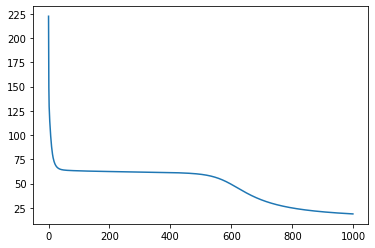

In [28]:
plt.plot(LOSS_VEC)

##### 6b: Plot decision boundary

In [29]:
# create a grid of values
x = np.linspace(-3, 3, 200)
X_vis = np.array([(x1, x2) for x1 in x for x2 in x])
# add the bias column
X_vis = add_bias(X_vis)

# calculate the (random) predictions
_, y_pred = feed_forward(X_vis, weights)

In [30]:
# reshape the predictions for visualization
Z = y_pred.reshape((len(x), len(x)), order='F')

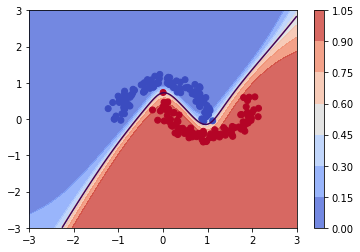

In [31]:
# draw a contour plot
fig,ax=plt.subplots(1,1)
cp = ax.contourf(x, x, Z, alpha=0.8, cmap='coolwarm')
ax.contour(x, x, Z, levels=[0.5])
fig.colorbar(cp) # Add a colorbar to a plot

# draw the original data
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')